# Project description

In this project, I will analyze which factors among cardiac health-related medical exam can predict a diagnosis of heart disease in patients from a dataset of 918 adult patients (male and female).

Please note that this analysis is made to follow a github tutorial and not to determine clearly which type of patient is prone or not to a diagnosis of heart disease.

# Data

The data can be downloaded here :
- https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction (fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved 02/18/2023 from https://www.kaggle.com/fedesoriano/heart-failure-prediction.)

The dataset (csv file) is stored locally in a "input_data" folder that is not pushed on github, thus this folder in included in a ".gitignore" file.

# Results

By using a logistic regression modeling with the optimization of hyperparameters, we are able to predict the heart attack diagnosis with an accuracy score of 0.9 and a recall equal to 0.88. The associated confusion matrix is presented below: 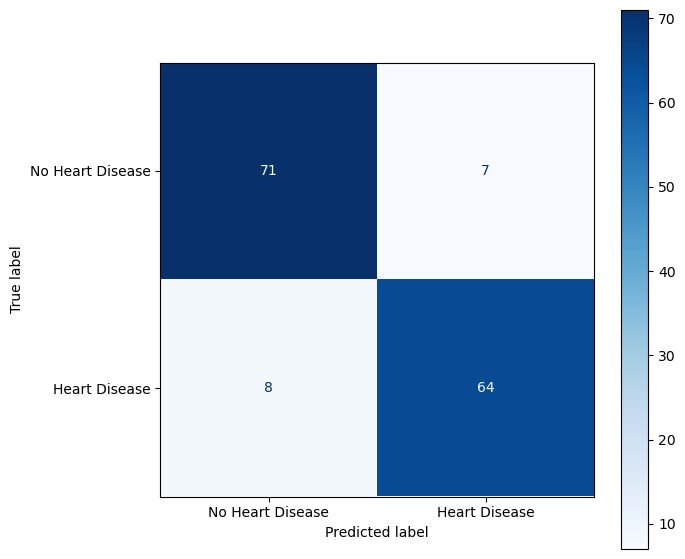

Analyzing feature importance showed which patient characteristics are the most important to predict the heart attack diagnosis:
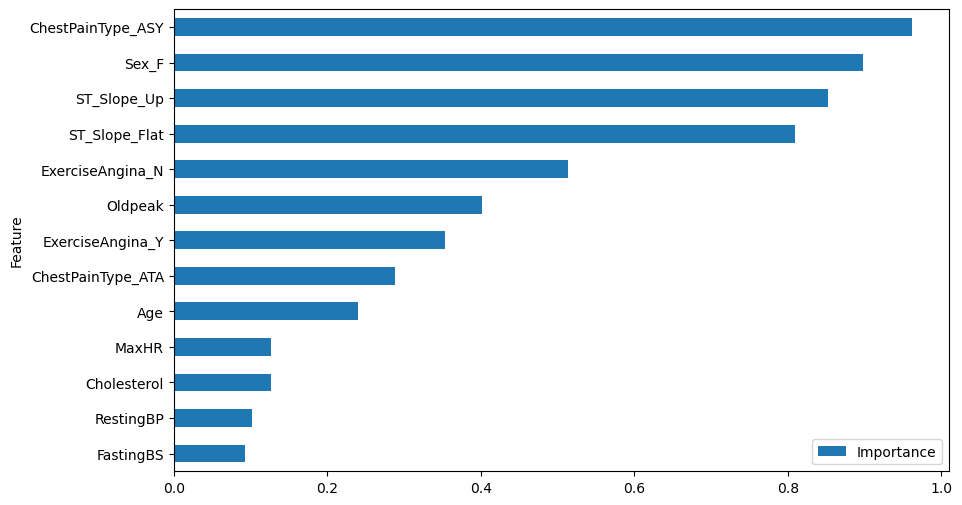

Interestingly, the model gives more importance to the asymptomatic chest pain type than any other feature. Being a female seems to be more important to diagnose a heart attack according to my model, compared to other features. Surprisingly, the age, the cholesterol level and blood pressure are less important than these previous features. 

# Notebook part

First, I will do an exploratory data analysis on the dataset. 
Then, I will use a logistic regression model and analyse its performance on predicting heart disease diagnosis as well as determine which features were the most important for this classification task.

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Import datasets I placed locally in the input_data folder
heart_data = pd.read_csv("input_data/heart.csv")

## Features description

In [3]:
# Examine the first rows
heart_data.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [4]:
heart_data.shape

(918, 12)

In [5]:
# First informations about the dataset
heart_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


The descriptions of columns is provided on kaggle following the dataset link.

- We have 918 rows, each corresponding to one patient.

- Their mean age is 53.5 years old, with a minimum of 28 years old and maximum or 77 years old.

- Both males and females are comprised in this dataset (M and F, respectively)

- "ChestPainType" corresponds to "chest pain type": TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic

- "RestingBP" corresponds to the resting blood pressure (in mm Hg). The mean resting blood pressure is equal to 132 mm Hg +/- 18.5 with a minimum value of 0 (probably false) and maximum value of 200. For information, according to the displayed values (and particularly the mean value of 131+-17 mmHg), these measures could be the systolic blood pressure. According to that, we can say that the patients all rather have high blood pressure.

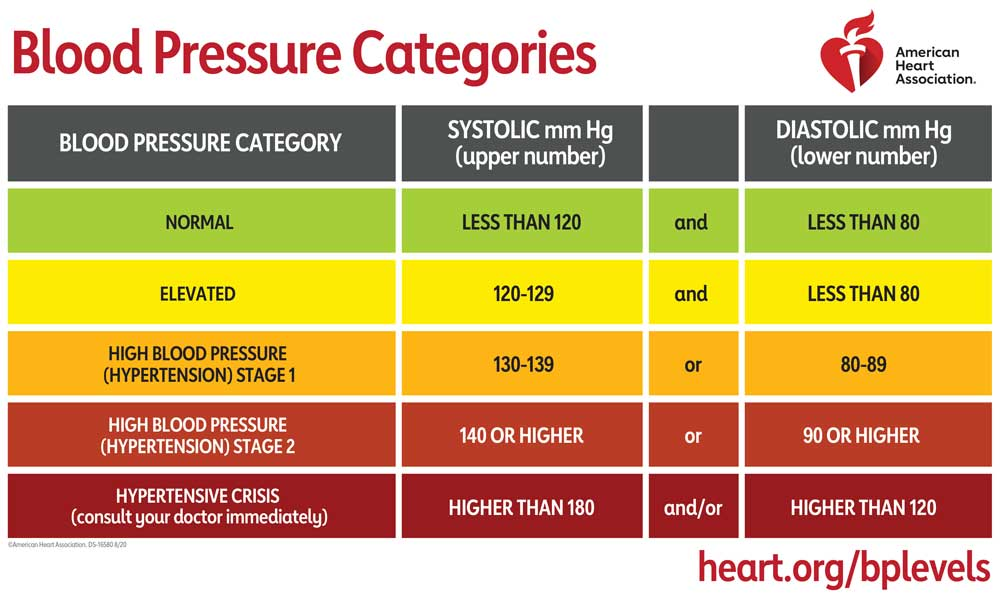

Source : https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

- "Cholesterol" are the cholesterol levels in the serum (mg/dL). Its mean is 198+-109 mg/dL with a minimum value of 126 mg/dL and a maximum value of 603/dL. Without further information, we will assume that it corresponds to total cholesterol levels in serum.

For information, normal serum cholesterol levels (mg/dL) for total cholesterol is <200 mg/dL. This means that patients have a higher than normal cholesterol level in mean.

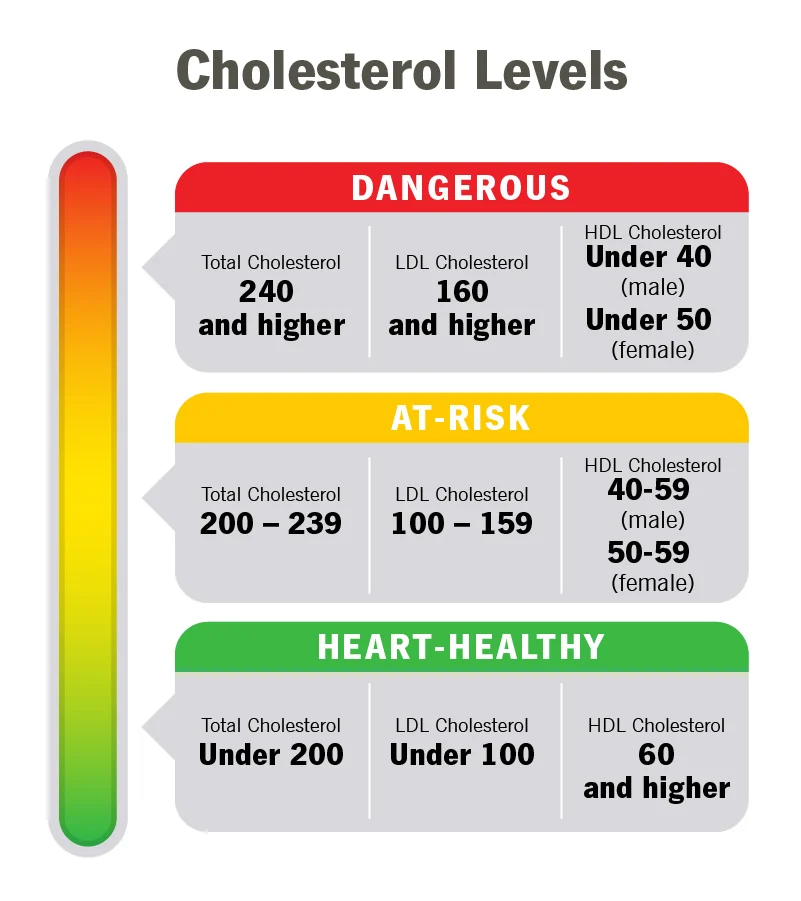

Source: https://my.clevelandclinic.org/health/articles/11920-cholesterol-numbers-what-do-they-mean

- "FastingBS": fasting blood sugar > 120 mg/dL (1 = true; 0 = false)

- "RestingECG": resting electrocardiogram results Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria

- "MaxHR": maximum heart rate achieved Numeric value between 60 and 202

- "ExerciseAngina": exercise induced angina (1 = yes, 0 = no)

- "OldPeak": oldpeak = ST Numeric value measured in depression

- "ST_Slope": the slope of the peak exercise ST segment Up: upsloping, Flat: flat, Down: downsloping

- "HeartDisease" : diagnosis of heart disease (angiographic disease status)
    - 0: < 50% diameter narrowing. less chance of heart disease
    - 1: > 50% diameter narrowing. more chance of heart disease
The output is slightly unbalanced towards 1 (more chance of heart disease), with a mean of 0.55. 

In [6]:
# Check if there are missing data
percent_missing = heart_data.isnull().sum() * 100 / len(heart_data)

In [7]:
percent_missing

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

In [8]:
# Check if there are duplicated rows
len(heart_data)-len(heart_data.drop_duplicates())

0

There are no missing data or duplicated rows in the original dataset.

## Distribution of features

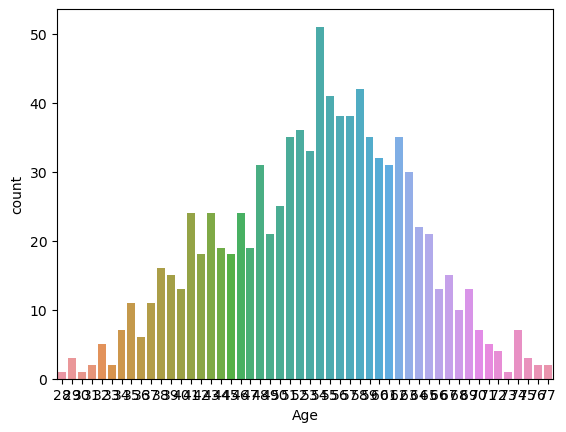

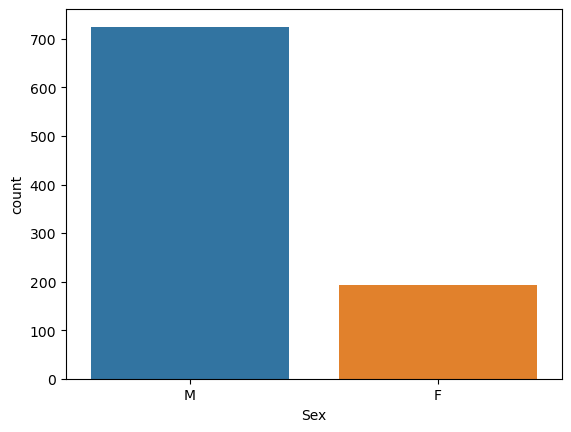

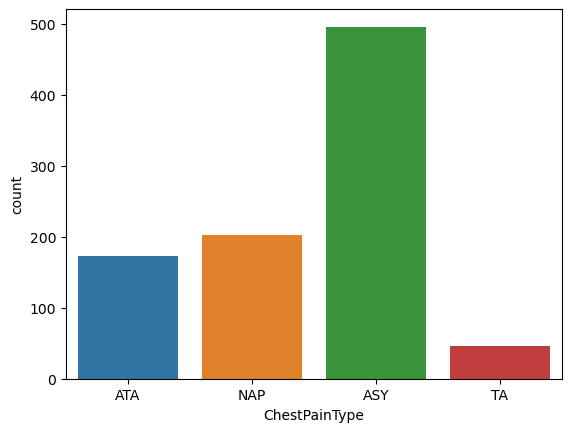

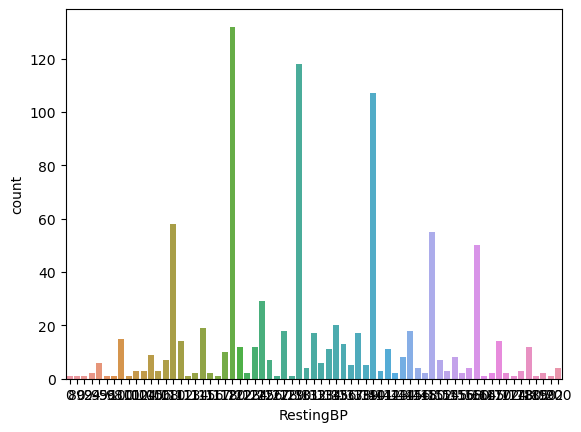

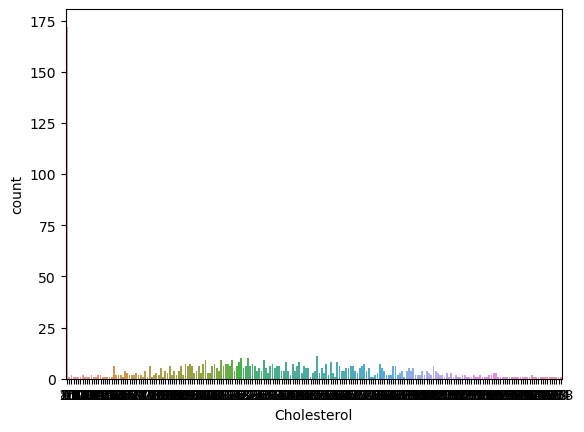

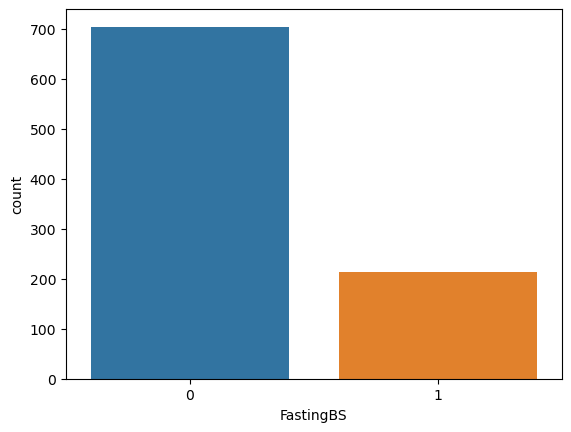

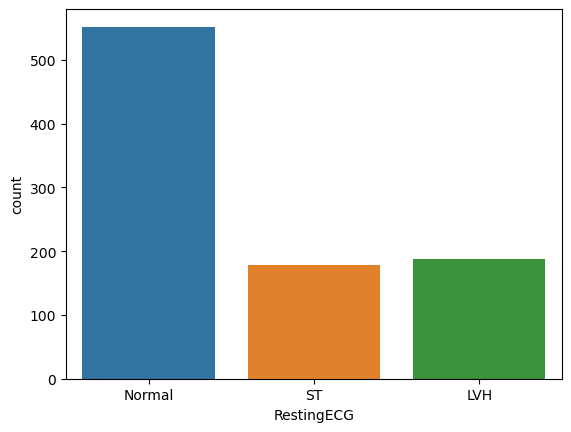

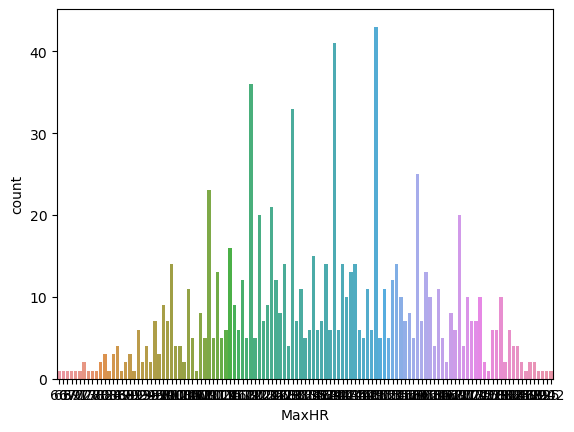

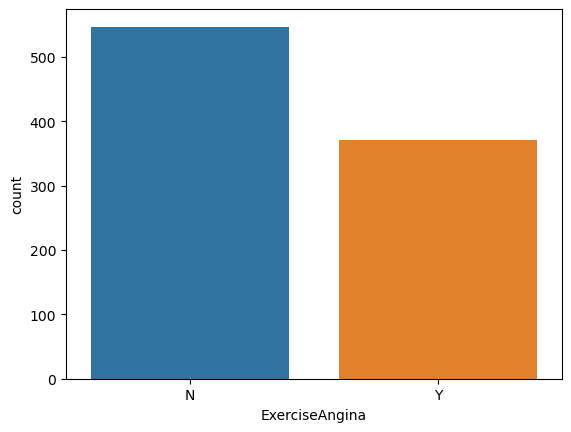

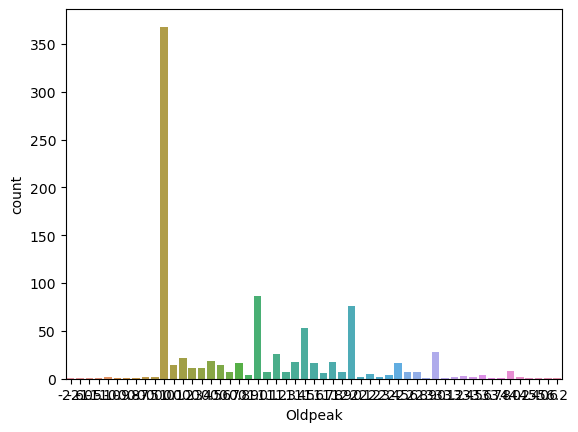

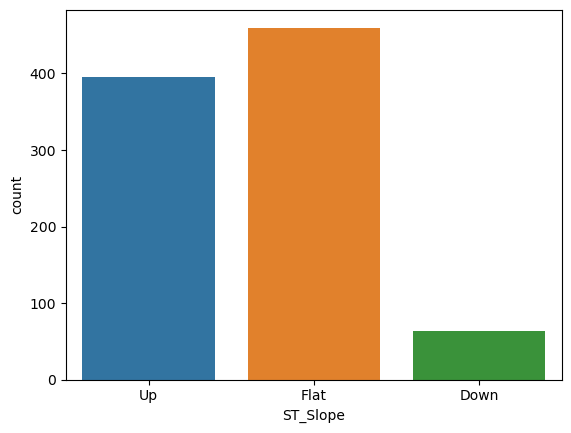

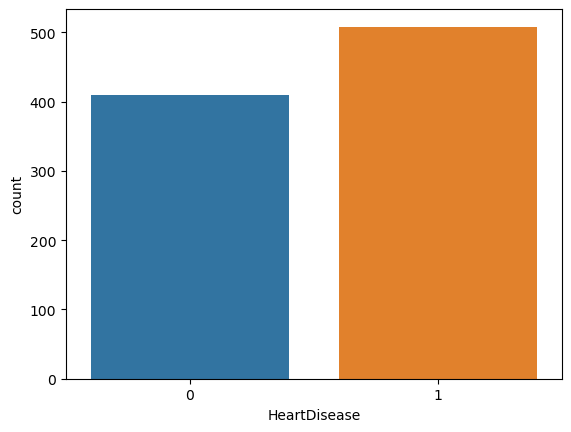

In [9]:
# Have a first graphical representation of each feature
for column in heart_data.columns:
    plt.figure()
    sns.countplot(x=heart_data[column])

## Outliers treatment

As seen before, a resting blood pressure equal to 0 would mean that the patient is dead. Therefore, we can observe if there are other outliers showing some constants that would be measure or entry errors:

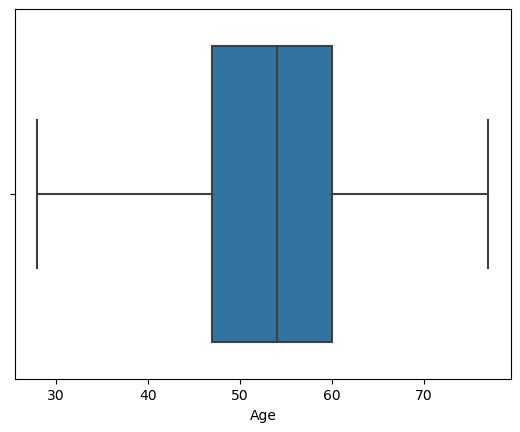

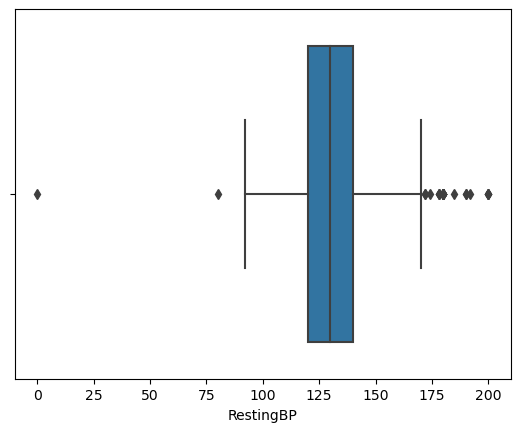

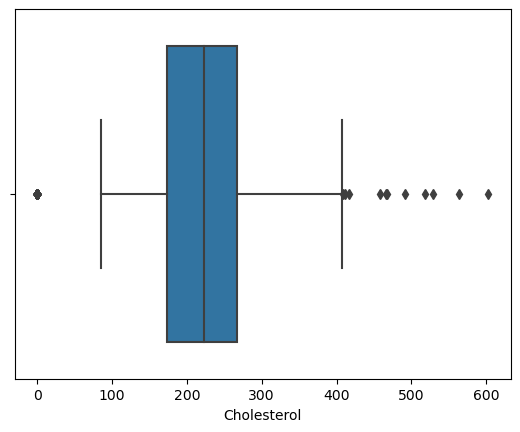

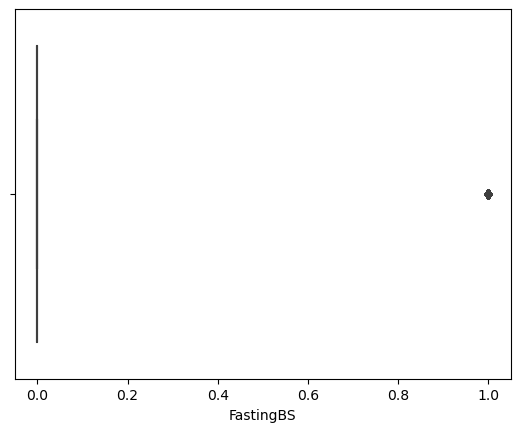

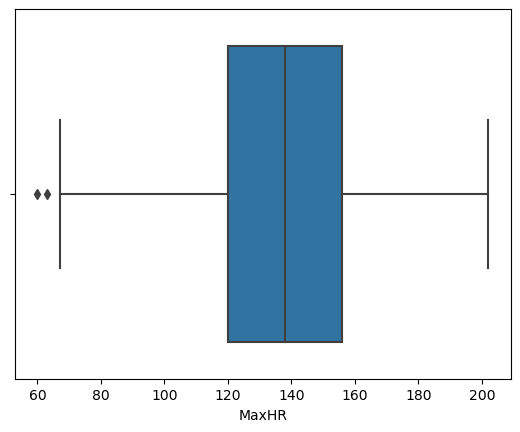

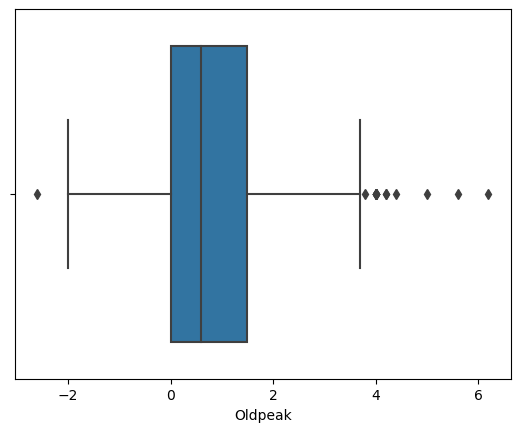

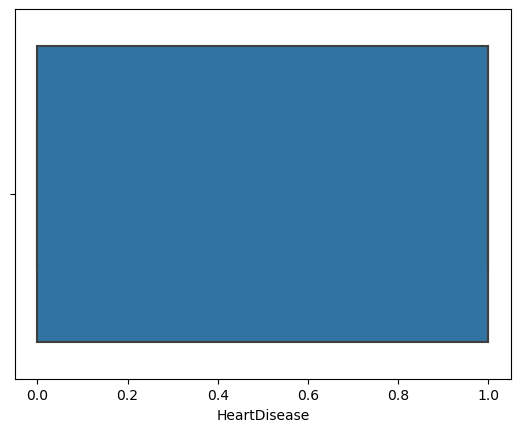

In [10]:
# Get numerical columns and create boxplots to observe if there are obvious outliers in the dataset that can be removed

numerical_columns = list(heart_data.select_dtypes(include=[np.number]).columns)

for num_column in numerical_columns:
    plt.figure()
    sns.boxplot(x=heart_data[num_column])

We can see that there is at least one patient having a resting blood pressure equal to 0 and a cholesterol level equal to 0 (which is virtually impossible). We will determine if these values are from the same patient or not.

In [11]:
heart_data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [12]:
heart_data[heart_data["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [13]:
heart_data[heart_data["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


There is indeed only one patient (index 449) that has a resting blood pressure equal to 0 in the dataset but 172 have a cholesterol level equal to 0 according to the dataset. This could be due to an absence of value that was written as "0" in the dataset.
I decide to remove all these rows for the following analysis.

In [14]:
heart_data_no_outliers = heart_data[heart_data.RestingBP != 0]
heart_data_no_outliers = heart_data_no_outliers[heart_data_no_outliers.Cholesterol != 0]

In [15]:
heart_data_no_outliers.shape

(746, 12)

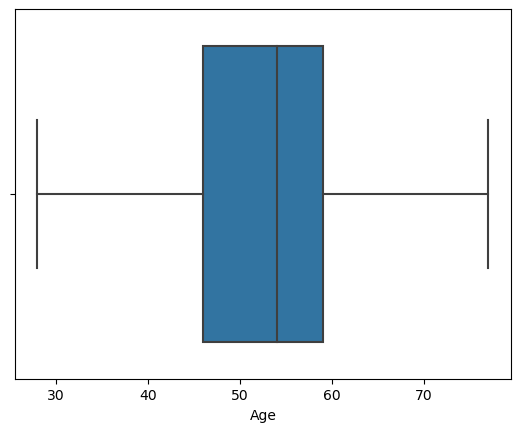

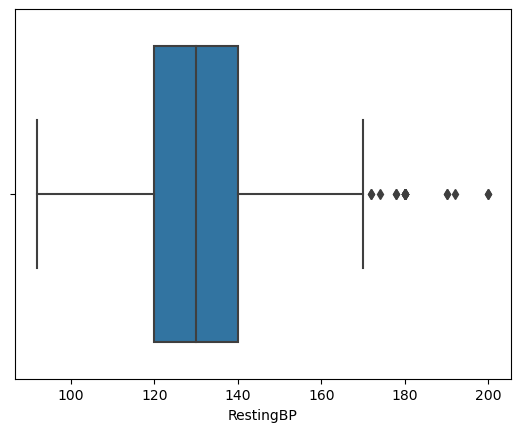

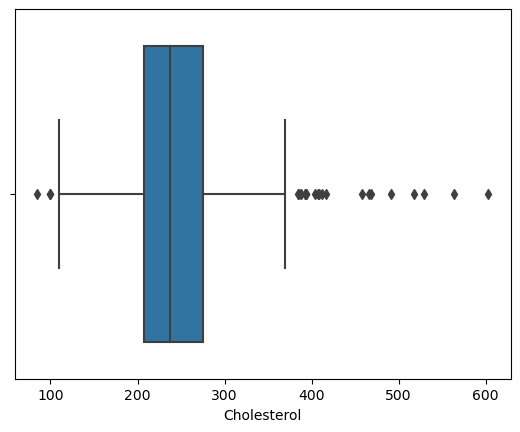

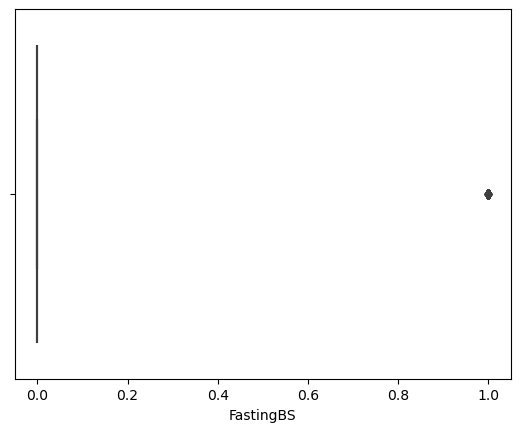

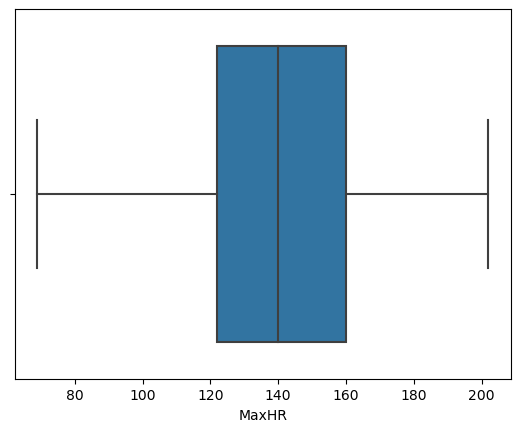

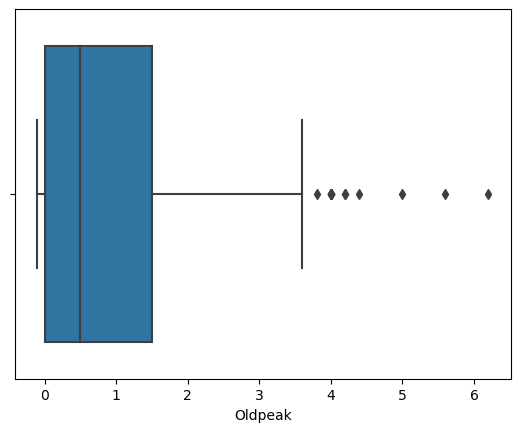

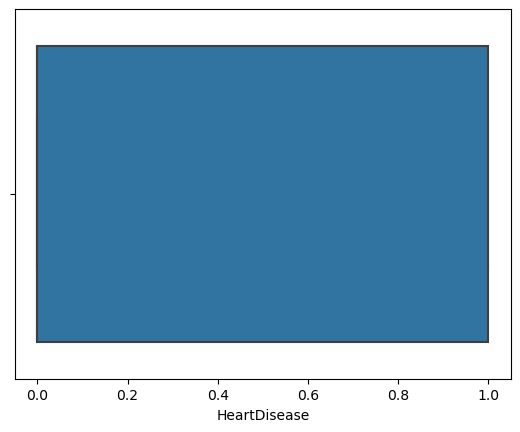

In [16]:
numerical_columns = list(
    heart_data_no_outliers.select_dtypes(include=[np.number]).columns
)

for num_column in numerical_columns:
    plt.figure()
    sns.boxplot(x=heart_data_no_outliers[num_column])

## Features distribution according to output

Let's see how the output of heart disease diagnosis is linked to our features:

In [17]:
heart_data_no_outliers.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

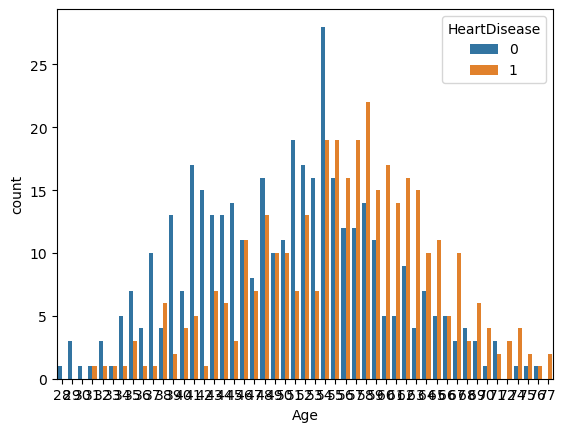

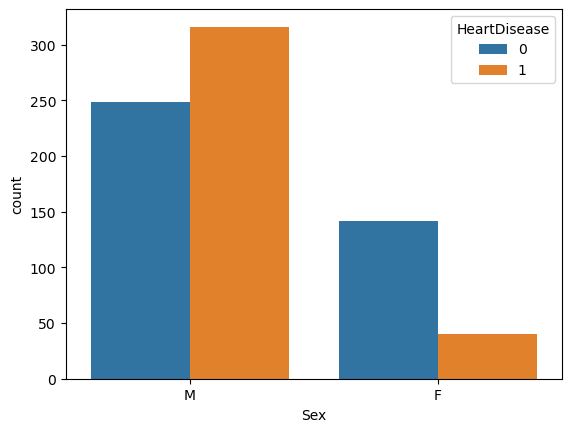

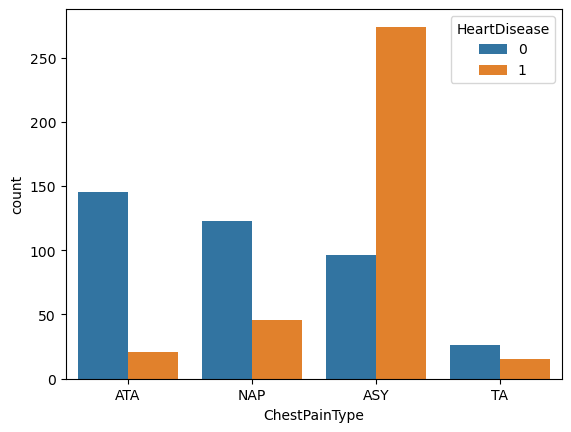

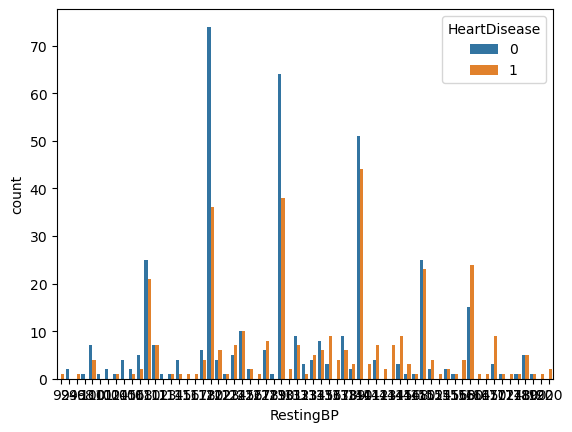

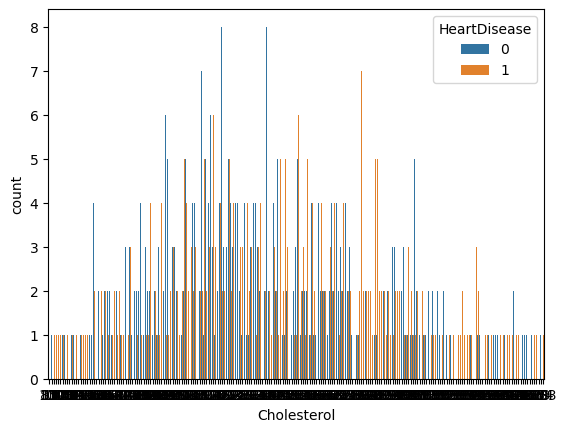

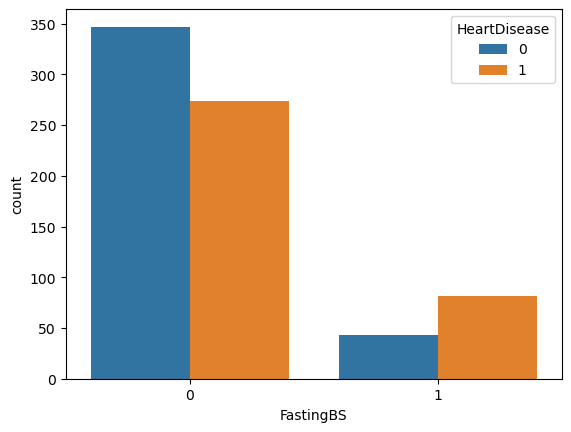

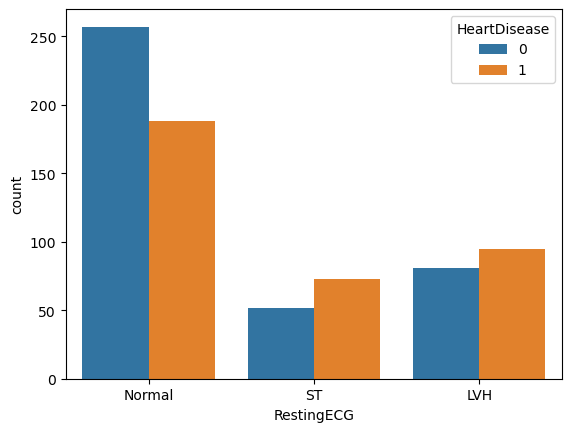

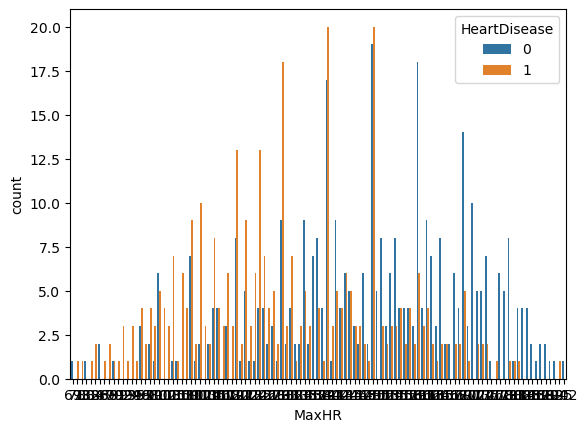

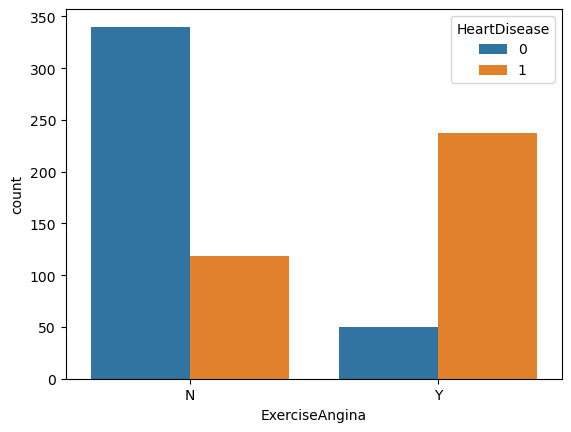

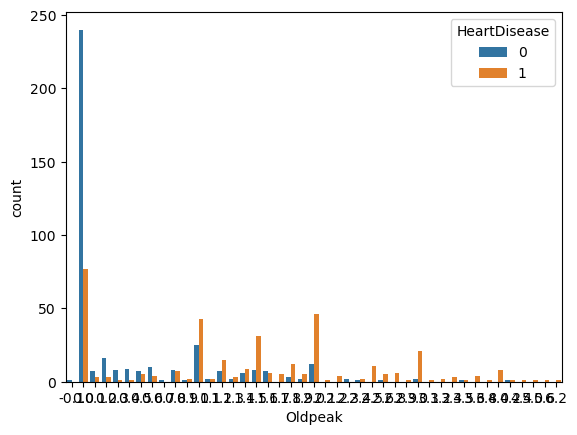

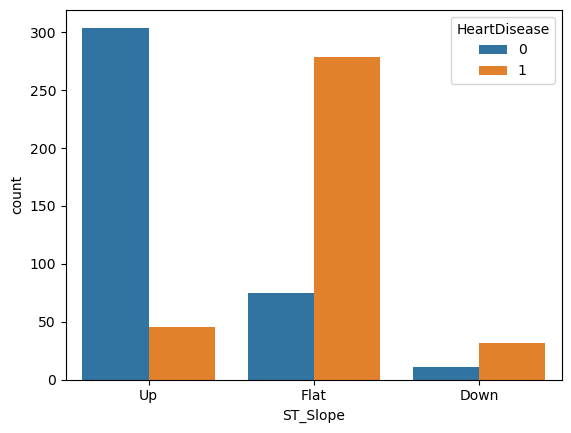

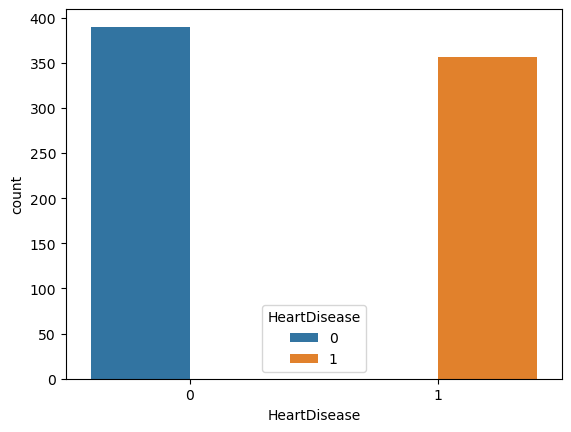

In [18]:
for column in heart_data_no_outliers.columns:
    plt.figure()
    sns.countplot(data=heart_data_no_outliers, x=column, hue="HeartDisease")

Older people, males compared to females, an ASY chest pain type, higher cholesterol levels (not very clear here), a lower maxHR, high fasting blood sugar, an ST or LVH resting ECG, the presence of exercise Angina, a medium/high value of oldpeak, a flat or down ST slope seem to correlate with a higher risk of heart disease diagnosis.

## Features correlation between them and with the heart disease diagnosis

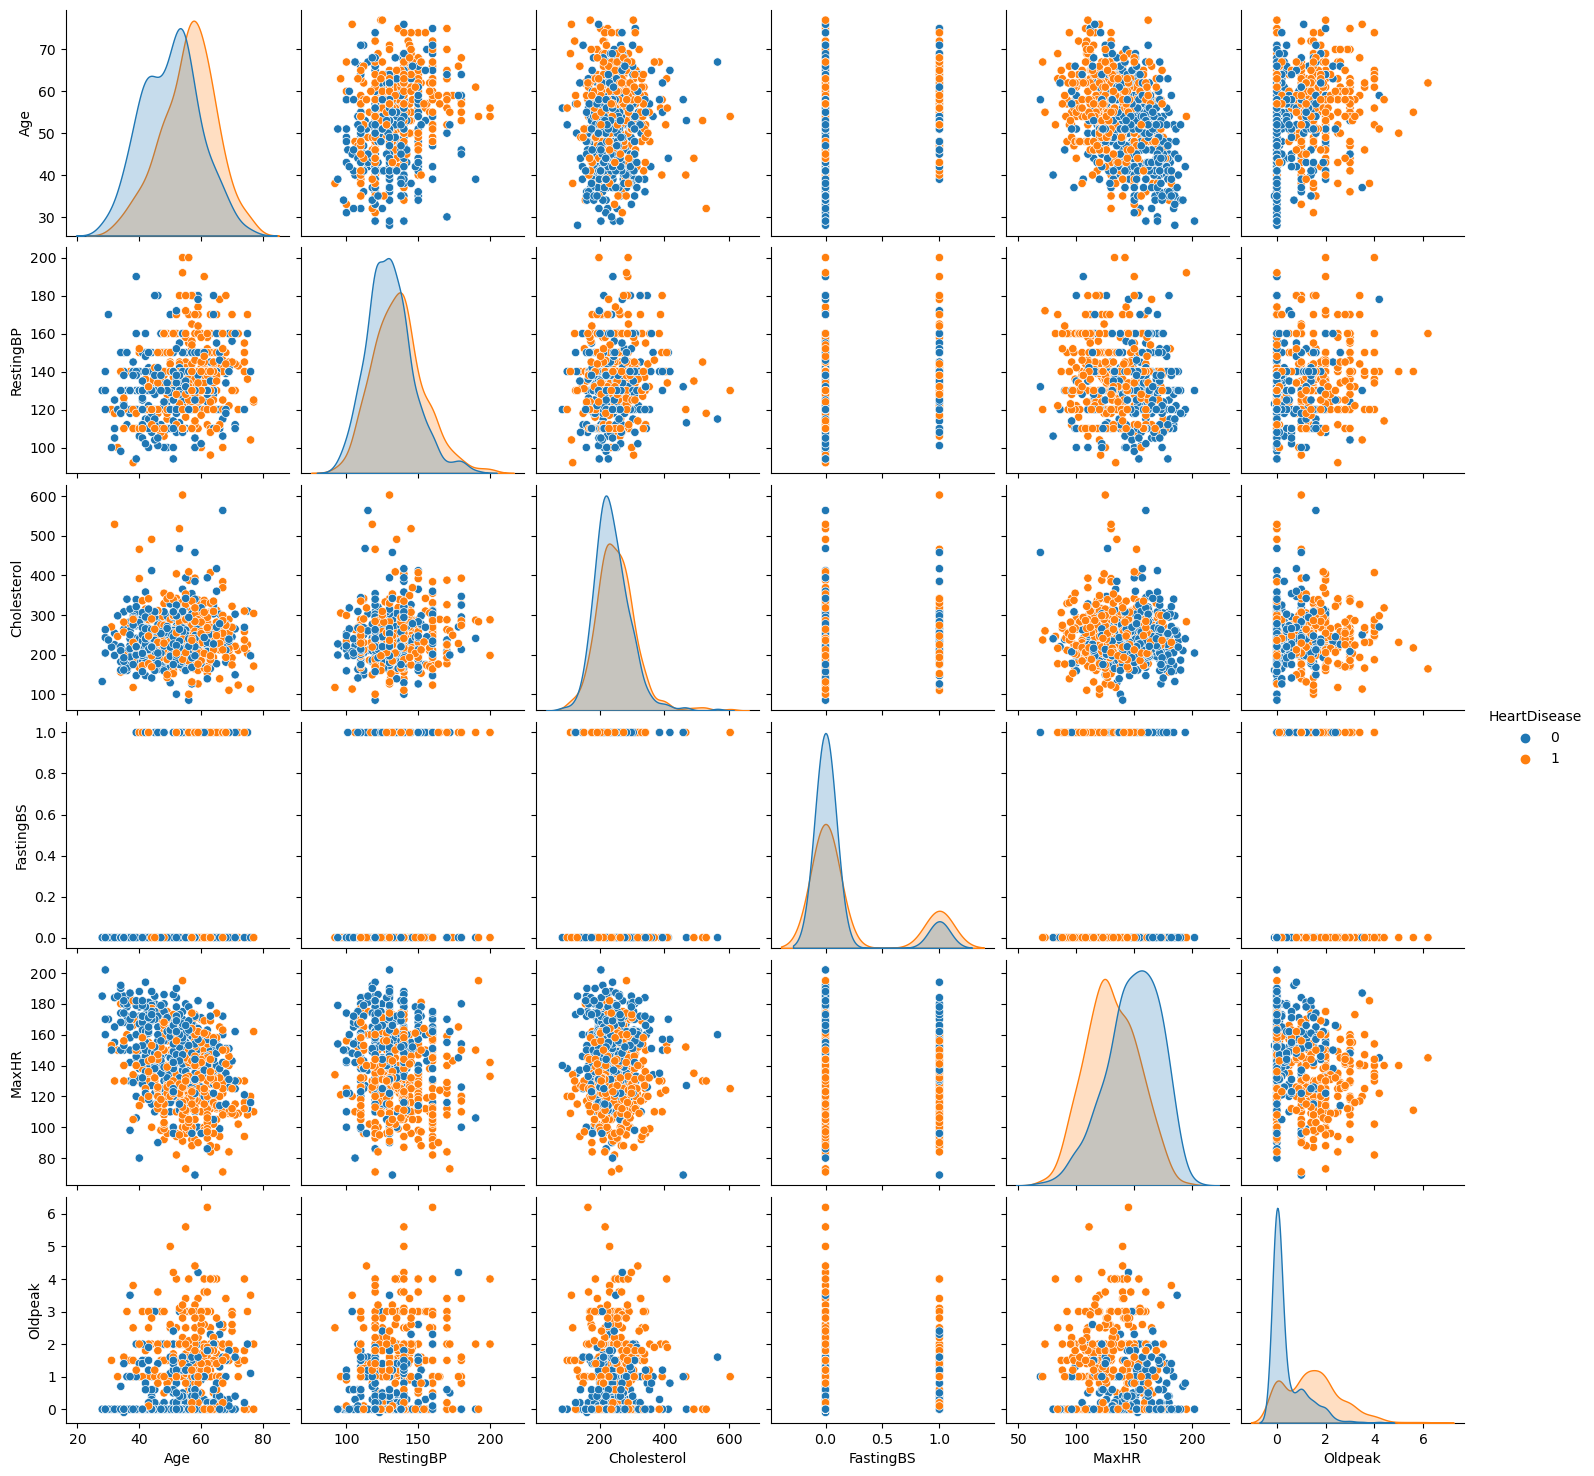

In [19]:
sns.pairplot(data=heart_data_no_outliers, hue="HeartDisease")
plt.show()

Age seems to be correlated to RestingBP (positively), MaxHR (negatively) and maybe Oldpeak values (positively) (but it has to be confirmed).
OldPeak and MaxHR also seem to be negatively correlated, while Oldpeak and RestingBP/Cholesterol seem positively correlated.

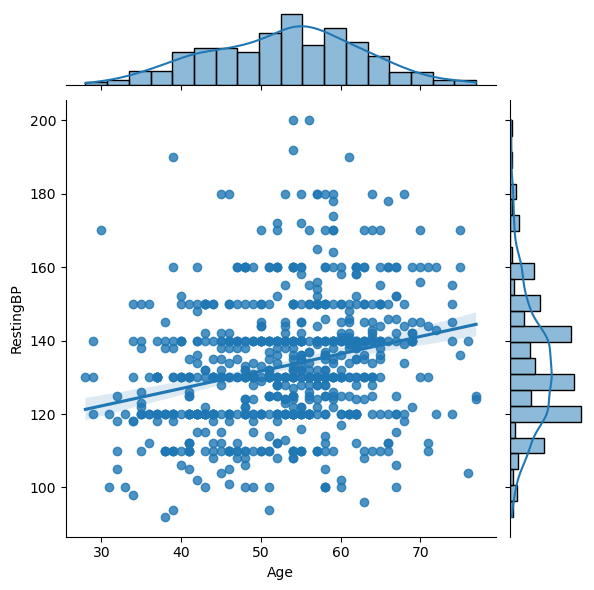

In [20]:
sns.jointplot(data=heart_data_no_outliers, x="Age", y="RestingBP", kind="reg")

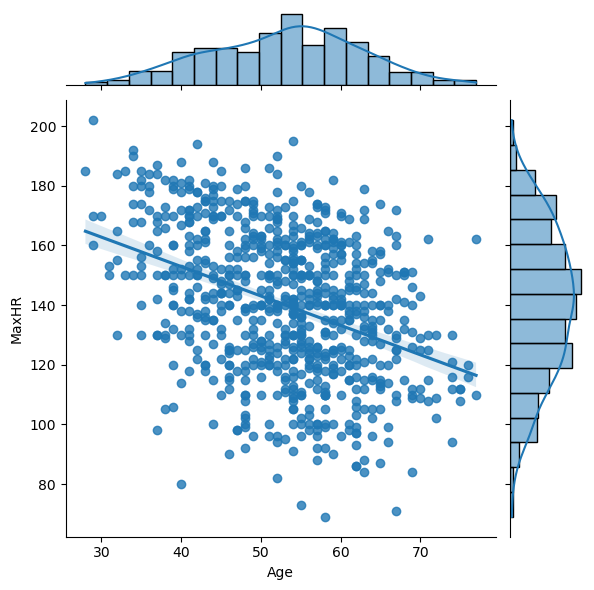

In [21]:
sns.jointplot(data=heart_data_no_outliers, x="Age", y="MaxHR", kind="reg")

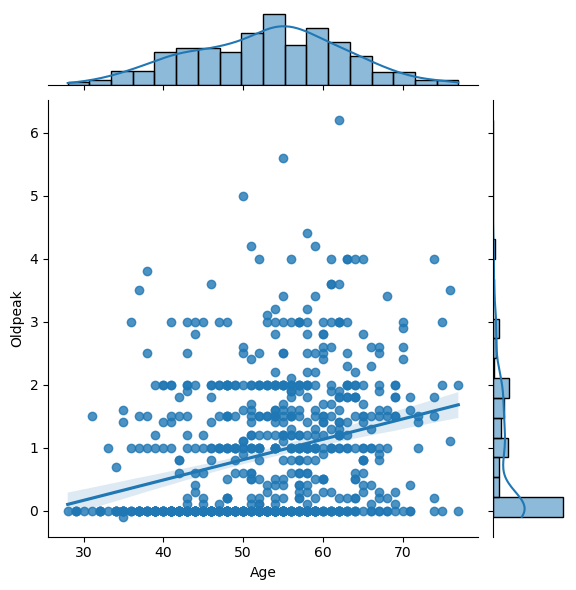

In [22]:
sns.jointplot(data=heart_data_no_outliers, x="Age", y="Oldpeak", kind="reg")

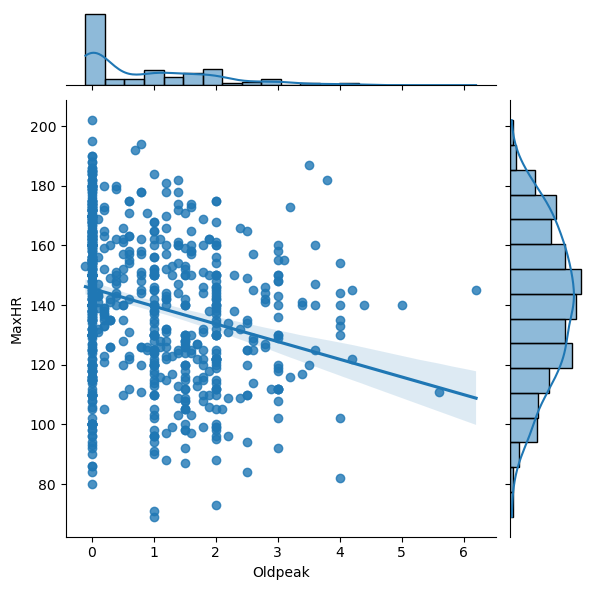

In [23]:
sns.jointplot(data=heart_data_no_outliers, x="Oldpeak", y="MaxHR", kind="reg")

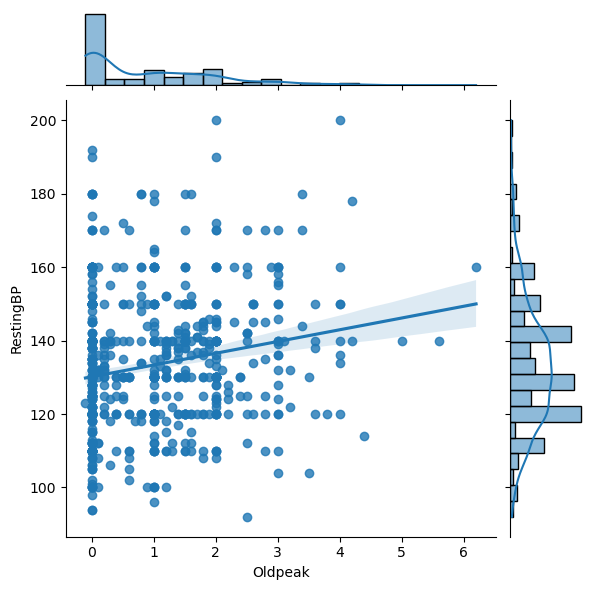

In [24]:
sns.jointplot(data=heart_data_no_outliers, x="Oldpeak", y="RestingBP", kind="reg")

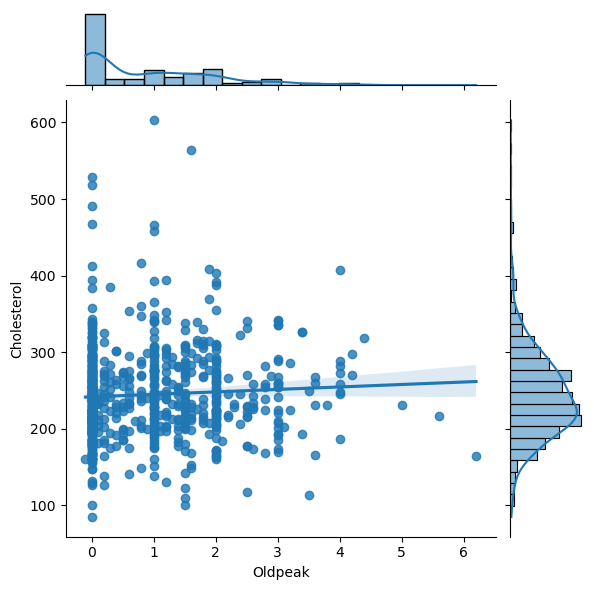

In [25]:
sns.jointplot(data=heart_data_no_outliers, x="Oldpeak", y="Cholesterol", kind="reg")

According to the previous jointplots, Cholesterol levels and Oldpeak are not correlated.

C:\Users\Melanie\AppData\Local\Temp\ipykernel_30636\504948536.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = np.triu(heart_data_no_outliers.corr(method="pearson"))
C:\Users\Melanie\AppData\Local\Temp\ipykernel_30636\504948536.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heart_data_no_outliers.corr(),


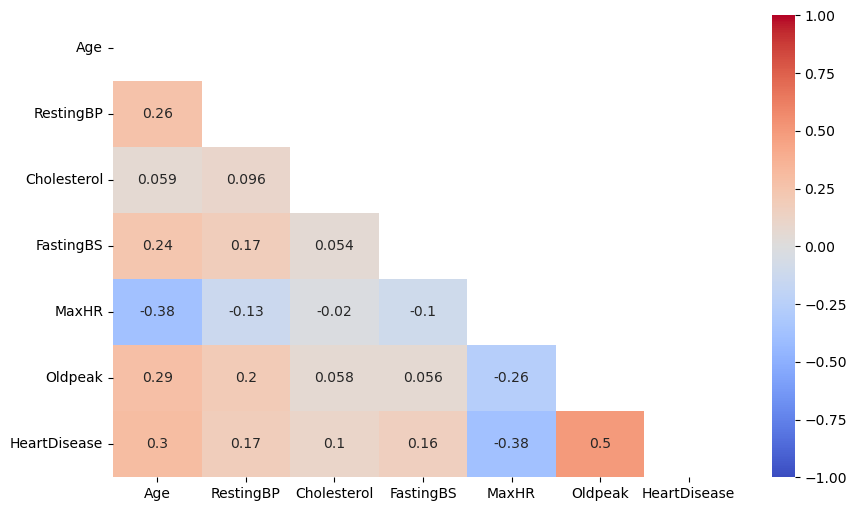

In [26]:
# Correlation matrix (a mask is used to plot only half of the symetrical matrix) (Pearson coefficient)
plt.figure(figsize=(10, 6))
matrix = np.triu(heart_data_no_outliers.corr(method="pearson"))
sns.heatmap(
    heart_data_no_outliers.corr(),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    mask=matrix,
)
plt.show()

We can confirm the negative Pearson correlation between age and MaxHR as well as the other positive correlations we observed before. These correlations are however quite weak with quite low correlation coefficients.

Interestingly, HeartDisease and Cholesterol levels do not seem to be correlated. HeartDisease and MaxHR are negatively correlated while OldPeak and Age are positively correlated to HeartDisease.

# Modelization

We are in the case of binary classification, with a target equal to 0 (no heart disease diagnosis) or 1 (heart disease diagnosis).
Different models can be tested:
- Support Vector Machines
- Naive Bayes
- Nearest Neighbor
- Decision Trees
- Logistic Regression
- Neural Networks

In this notebook, we will consider a logistic regression model.

## Model setup

### Hyperparameters tuning

There are three main parameters to tune during logistic regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):
- solver ({‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’). The choice of the solver depends on the penalty.
- penalty ({‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’)
- regularization strength (C\[float\], default=1.0, which is the inverse of regularization strength)


In [27]:
# Separate data into X (features) and y (target)
x_columns = [x for x in heart_data_no_outliers.columns if x != 'HeartDisease']
X = heart_data_no_outliers[x_columns]
y = heart_data_no_outliers['HeartDisease']

In [28]:
# categorical features will be one hot encoded, we need to separate the categorical and numerical features
numeric_features = list(
    X.select_dtypes(include=[np.number]).columns
)

categorical_features = list(
    X.select_dtypes(exclude=[np.number]).columns
)

In [29]:
# Check categorical features list
categorical_features

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [30]:
# Check numeric features list
numeric_features

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

In [31]:
# Set the numerical transformer: the data will be scaled. A simple imputer is included even if there are no missing data, in prevention of a future change in dataset
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


In [32]:
# Set the categorical transformer: one hot encoder followed by a feature selection according to the chi² test
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

In [33]:
# Set the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [34]:
# Setup the classifier pipeline
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

In [35]:
# Separate training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
# Set the grid of hyperparameters
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__max_iter': list(range(100,800,100)),
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [37]:
# Look for the best hyperparameters
grid = GridSearchCV(clf, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1, scoring = 'recall')

In [40]:
# Fit
grid.fit(X_train,y_train)

Fitting 3 folds for each of 490 candidates, totalling 1470 fits


C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
441 fits failed out of a total of 1470.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
147 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Melanie\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_e

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'FastingBS',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('selector',
                                                                                          SelectPer...
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ExerciseAngina',
                                                                          'ST_Slope'])])),
                                       ('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'classifier__max_iter': [100, 200, 300, 400, 500, 600,
                                                  700],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='recall', verbose=True)

The "FitFailedWarning: 441 fits failed out of a total of 1470." is expected since some classifiers are not compatible with the l1 penalization.

In [41]:
# Get the best parameters
grid.best_params_

{'classifier__C': 0.1,
 'classifier__max_iter': 100,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [42]:
print(
    "Recall of the best model: "
    f"{grid.score(X_test, y_test):.3f}"
)

Recall of the best model: 0.889


### Model results with the best hyperparameters

In [43]:
# Train on full training data
best_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(C=0.1, max_iter=100, penalty='l2', solver='liblinear'))]
)

best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'FastingBS',
                                                   'MaxHR', 'Oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x0000027CFD8234C0>))]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier', LogisticRegression(C=0.1, solver='liblinear'))])

In [44]:
# Predict on test data and determine the recall
y_pred = best_clf.predict(X_test)
recall_score(y_test, y_pred)

0.8888888888888888

In [45]:
# Check the accuracy
accuracy_score(y_test, y_pred)

0.9

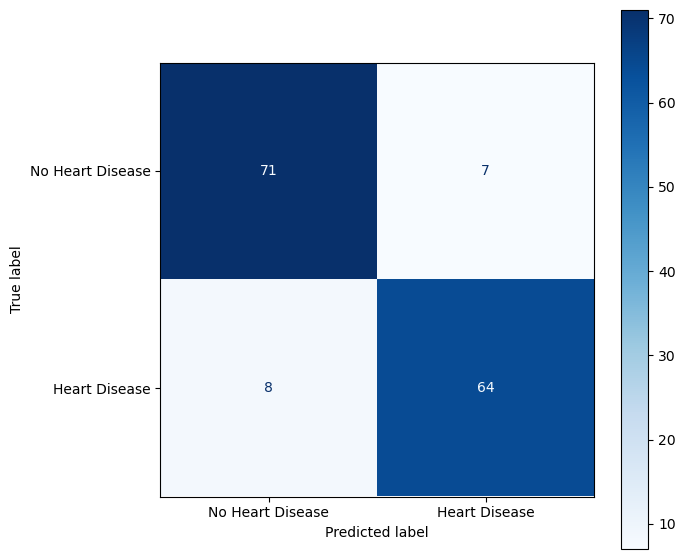

In [46]:
# Confusion matrix plot
fig, ax = plt.subplots(figsize=(7, 7))
cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Heart Disease", "Heart Disease"]
)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Feature importance

Here I will examine the features importance for the class 1 which corresponds to Heart Disease prediction.

In [70]:
# Get all features names including those obtained after one hot encoding
list_features = best_clf.named_steps["preprocessor"].get_feature_names_out().tolist()
list_features

['num__Age',
 'num__RestingBP',
 'num__Cholesterol',
 'num__FastingBS',
 'num__MaxHR',
 'num__Oldpeak',
 'cat__Sex_F',
 'cat__ChestPainType_ASY',
 'cat__ChestPainType_ATA',
 'cat__ExerciseAngina_N',
 'cat__ExerciseAngina_Y',
 'cat__ST_Slope_Flat',
 'cat__ST_Slope_Up']

In [73]:
# Clean the features list
list_features_clean = [i.split("__", 1)[1] for i in list_features]
list_features_clean

['Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak',
 'Sex_F',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [80]:
# Get the associated coefficients
coefficients = best_clf["classifier"].coef_

<Axes: ylabel='Feature'>

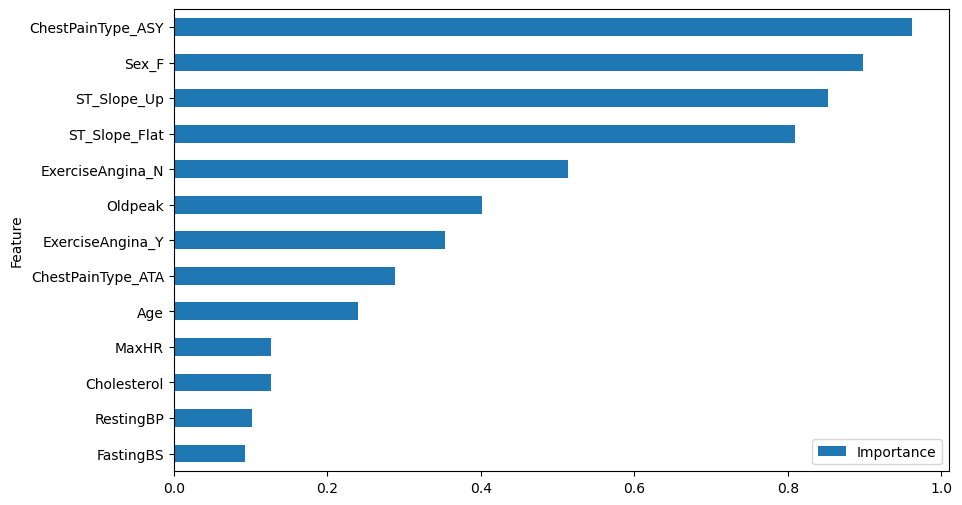

In [76]:
# Determine and plot features importance
avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame(
    {"Feature": list_features_clean, "Importance": avg_importance}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

Interestingly, the model gives more importance to the asymptomatic chest pain type than any other feature. Being a female seems to be more important to diagnose a heart attack according to my model, compared to other features. Surprisingly, the age, the cholesterol level and blood pressure are less important than these previous features.  